In [1]:
import os
import cv2
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomPosterize(bits=2),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),

    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomPosterize(bits=2),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])    
}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

root_dir = '../../dataset'
train_data = torchvision.datasets.ImageFolder(
    root=os.path.join(root_dir, 'train'),
    transform=data_transforms['train']
)

val_data = torchvision.datasets.ImageFolder(
    root=os.path.join(root_dir, 'val'),
    transform=data_transforms['val']
)

In [3]:
class_names = train_data.classes
dataset_sizes = {'train': len(train_data), 'val': len(val_data)}

dataloaders = {  
    'train': Data.DataLoader(
        dataset=train_data,
        batch_size=32,
        shuffle=True,
    ),

    'val': Data.DataLoader(
        dataset=val_data,
        batch_size=1,
        shuffle=True,
    ),    
}

In [4]:
def imshow(image, title=None):
    image = image.numpy().transpose((1, 2, 0)) 
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = image * std + mean
    image = np.clip(image, 0, 1)
    plt.imshow(image)
    if title:
        plt.title(title)
        
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    for step, (images, labels) in enumerate(dataloaders['val']): 
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = torch.max(outputs, 1)[1]
        
        for i in range(images.size(0)):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[i]]))
            imshow(images.cpu().data[i])
            
            if images_so_far == num_images:
                model.train(mode=was_training)
                return
    
    model.train(mode=was_training)

In [5]:
vgg = torchvision.models.vgg16(pretrained=True) 

class VGG(torch.nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.vgg = torchvision.models.vgg16(pretrained=True) 
        self.conv = nn.Sequential(
            self.vgg.features, 
            self.vgg.avgpool 
        )
        self.fc = nn.Linear(512, 5)

    def forward(self,x):    
        x = self.conv(x)
        x = x.view(-1, 512, 7*7).mean(2)
        x = self.fc(x)
        return x 

def train_model(model, loss_fn, optimizer, scheduler, num_epochs=25):
    
    best_accuracy = 0.0
    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        
        step_loss = 0.0
        epoch_accuracy = 0.0
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            step_loss = 0.0
            step_corrects = 0
            
            for step, (images, labels) in enumerate(dataloaders[phase]):      
               
                images, labels = images.to(device), labels.to(device)
                outputs = model(images) 
                preds = torch.max(outputs, 1)[1]
                loss = loss_fn(outputs, labels)
                
                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                step_loss += loss.item() * images.size(0)
                step_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = step_loss / dataset_sizes[phase]
            epoch_accuracy = step_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Accuracy: {:.4f}'.format(
                phase, epoch_loss, epoch_accuracy))

            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_accuracy)
            else:
                val_loss.append(epoch_loss)
                val_acc.append(epoch_accuracy)

            if phase == 'val' and epoch_accuracy > best_accuracy:
                best_accuracy = epoch_accuracy
        print()
        
    print('Best Validation Accuracy: {:4f}'.format(best_accuracy))

    x = np.arange(num_epochs)
    plt.subplot(221)
    plt.plot(x, train_loss, c='red', label='train loss')
    plt.plot(x, val_loss, c='blue', label='val loss')
    plt.legend(loc='best')

    plt.subplot(222)
    plt.plot(x, train_acc, c='red', label='train acc')
    plt.plot(x, val_acc, c='blue', label='val acc')
    plt.legend(loc='best')

    plt.show()

    return model

In [6]:
model = VGG()
model = model.to(device)

trainable_parameters = []
for name, p in model.named_parameters():
    if "fc" in name:
        trainable_parameters.append(p)

loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(trainable_parameters, lr=0.001, momentum=0.9)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Epoch 1/10
train Loss: 1.4576 Accuracy: 0.5511
val Loss: 1.2751 Accuracy: 0.8131

Epoch 2/10
train Loss: 1.1063 Accuracy: 0.8554
val Loss: 0.9837 Accuracy: 0.9192

Epoch 3/10
train Loss: 0.8518 Accuracy: 0.9589
val Loss: 0.7911 Accuracy: 0.9798

Epoch 4/10
train Loss: 0.6971 Accuracy: 0.9800
val Loss: 0.6720 Accuracy: 0.9747

Epoch 5/10
train Loss: 0.5928 Accuracy: 0.9813
val Loss: 0.5821 Accuracy: 0.9848

Epoch 6/10
train Loss: 0.5084 Accuracy: 0.9838
val Loss: 0.5119 Accuracy: 0.9747

Epoch 7/10
train Loss: 0.4520 Accuracy: 0.9825
val Loss: 0.4716 Accuracy: 0.9798

Epoch 8/10
train Loss: 0.4260 Accuracy: 0.9913
val Loss: 0.4502 Accuracy: 0.9899

Epoch 9/10
train Loss: 0.4197 Accuracy: 0.9913
val Loss: 0.4543 Accuracy: 0.9899

Epoch 10/10
train Loss: 0.4114 Accuracy: 0.9913
val Loss: 0.4515 Accuracy: 0.9798

Best Validation Accuracy: 0.989899


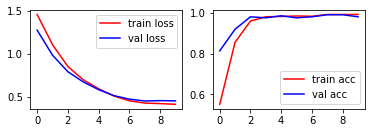

In [7]:
model = train_model(model, loss_fn, optimizer, exp_lr_scheduler, num_epochs=10)

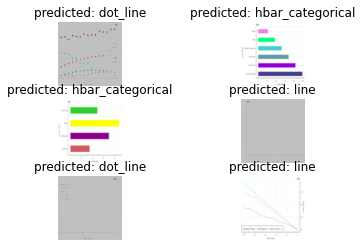

In [8]:
visualize_model(model)

In [9]:
torch.save(model.state_dict(), 'ckpt.pth')